# Text Classification

## Problem Description

Train a deep neural network for classification tickets(‘body’ column) data with respect to ‘urgency’. 

__The purpose here is to get familiar with Recurrent Neural Networks, LSTMs, Keras API, hyper parameter tuning and validating the results.__

## Load libs

In [56]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import model_from_json, load_model


# fix random seed for reproducibility
numpy.random.seed(7)

## Load dataset

In [57]:
# load pima indians dataset
ticketData = pd.read_csv(
    #"/Users/samyam/Documents/Samya/GIT/insofe/Cute_AI_DL/TextAnalysis/all_tickets-1551435513304.csv", 
    "../input/glove-testone1/all_tickets-1551435513304.csv",
    delimiter=",")

print(ticketData.shape)
ticketData.head()

(48549, 9)


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


## Analyze and Process data

We need to find target column "urgency" based on "body" column, hence remove other columns

In [58]:
ticketData_1 = ticketData[['body', 'urgency']]
ticketData_1.head()

,body,urgency
0,hi since recruiter lead permission approve req...,3
1,icon dear please setup icon per icon engineers...,3
2,work experience user hi work experience studen...,3
3,requesting meeting hi please help follow equip...,3
4,re expire days hi ask help update passwords co...,3


### Is the data balanced?

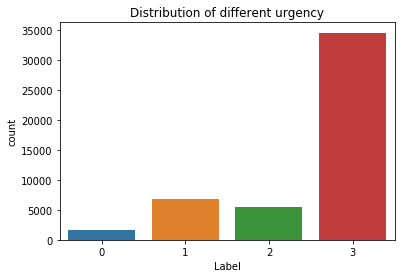

In [59]:
sns.countplot(ticketData_1.urgency)
plt.xlabel('Label')
plt.title('Distribution of different urgency');

### Create label encoding of the target variable

In [60]:
X = ticketData_1.body
Y = ticketData_1.urgency

Y = Y.values.reshape(-1,1)

print(X.shape)
print(Y.shape)

(48549,)
(48549, 1)


### Split into training and test data.

In [61]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

print(X_train.shape)
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)


(41266,)
(7283,)
(41266,)
(7283, 1)


In [62]:
print(X_train[:1])
print(Y_train[:1])

26705    tuesday november re phone requirement hi pleas...
Name: body, dtype: object
[[3]]


### Process the data

1. Tokenize the data and convert the text to sequences.
2. Add padding to ensure that all the sequences have the same shape.
3. Set embedding dimension

In [63]:
#length of body
max_ticket_body_length_in_words = 500
max_words = 5000

#num_words: the maximum number of words to keep, based on word frequency. 
#Only the most common num_words-1 words will be kept.
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

word_Index = tok.word_index
vocab_Size = len(word_Index) + 1
print('Found %s unique tokens.' % vocab_Size)


sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_ticket_body_length_in_words) #maxlen: Int, maximum length of all sequences.


Found 11786 unique tokens.


In [64]:
print(sequences_matrix.shape)
sequences_matrix

(41266, 500)


array([[   0,    0,    0, ...,    9,  388,  204],
       [   0,    0,    0, ...,   39,   26,   28],
       [   0,    0,    0, ...,   36,  392,   71],
       ...,
       [   0,    0,    0, ...,   12,    4,   83],
       [   0,    0,    0, ..., 2876,   39,   26],
       [   0,    0,    0, ...,   39,  620,   28]], dtype=int32)

## Define model

In [65]:
embedding_vector_max_len = 32

def custom_RNN():
    inputs = Input(name='inputs',shape=[max_ticket_body_length_in_words])
    layer = Embedding(input_dim = max_words,
                      output_dim = embedding_vector_max_len,
                      input_length=max_ticket_body_length_in_words)(inputs)
    layer = LSTM(64)(layer)
    
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=inputs,outputs=layer)
    return model

In [66]:
model = custom_RNN()
model.summary()

adam = Adam(lr=.001, beta_1=.9, beta_2=.99)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
___________________________

## Train the model

In [67]:
model.fit(sequences_matrix,to_categorical(Y_train),batch_size=128,
          epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


Train on 33012 samples, validate on 8254 samples
Epoch 1/10
33012/33012 [==============================] - 187s 6ms/step - loss: 0.4503 - acc: 0.8093 - val_loss: 0.3013 - val_acc: 0.8431
Epoch 2/10
33012/33012 [==============================] - 186s 6ms/step - loss: 0.3011 - acc: 0.8425 - val_loss: 0.2932 - val_acc: 0.8447
Epoch 3/10
33012/33012 [==============================] - 186s 6ms/step - loss: 0.2864 - acc: 0.8473 - val_loss: 0.2934 - val_acc: 0.8442


## Evaluate on train data 

In [68]:
accr = model.evaluate(sequences_matrix,to_categorical(Y_train))
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


41266/41266 [==============================] - 297s 7ms/step
Train set
  Loss: 0.282
  Accuracy: 0.850


## Predict on test data

In [69]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_ticket_body_length_in_words)
Y_pred = model.predict(test_sequences_matrix)
print(Y_pred)

[[7.5958205e-08 2.7531328e-07 6.2554460e-07 9.9999905e-01]
 [1.6329520e-06 4.3989116e-06 7.5008265e-06 9.9998641e-01]
 [1.7733386e-08 7.2241242e-08 1.7610300e-07 9.9999976e-01]
 ...
 [1.0778215e-01 4.8871887e-01 4.0347883e-01 2.0161920e-05]
 [7.8720559e-09 3.2403452e-08 7.6808071e-08 9.9999988e-01]
 [2.8514457e-08 1.1442662e-07 2.8139780e-07 9.9999964e-01]]


In [70]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))
print(y_pred)

[3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 

In [71]:
# calculate accuracy of class predictions
from sklearn import metrics
print("Prediction accuracy on test data :",metrics.accuracy_score(Y_test, y_pred)*100)

Prediction accuracy on test data : 85.44555814911438


In [72]:
#Confusion Matric
metrics.confusion_matrix(Y_test, y_pred)

array([[   0,  216,   14,    2],
       [   0,  978,   19,   17],
       [   0,  763,   16,   14],
       [   0,    5,   10, 5229]])

## Transfer learning

Using existing embeddings

### Preparing the Embedding layer

In [73]:
embeddings_index = {}
f = open('../input/glove-testone/glove_6B_50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [74]:
#Create placeholder for all unique words & there embeddings (50, in the glove case)
embedding_Matrix = np.zeros((vocab_Size, 50))
for word, i in word_Index.items():
    embedding_Vector = embeddings_index.get(word)
    if embedding_Vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_Matrix[i] = embedding_Vector

print (embedding_Matrix.shape)

(11786, 50)


### Create the embedding layer

In [75]:
max_ticket_body_length_in_words = 500

embedding_layer = Embedding(vocab_Size,
                            50,
                            weights=[embedding_Matrix],
                            input_length=max_ticket_body_length_in_words,
                            trainable=False)

In [76]:
def custom_RNN_1():
    inputs = Input(name='inputs',shape=[max_ticket_body_length_in_words], dtype='int32')
    embedded_sequences = embedding_layer(inputs)
    layer = LSTM(64)(embedded_sequences)
    
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    
    model = Model(inputs=inputs,outputs=layer)
    return model

In [77]:
model_1 = custom_RNN_1()
model_1.summary()

adam = Adam(lr=.001, beta_1=.9, beta_2=.99)
model_1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 500)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 50)           589300    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                 1028      
__________

### Train the model

In [78]:
model_1.fit(sequences_matrix,to_categorical(Y_train),batch_size=128,
          epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


Train on 33012 samples, validate on 8254 samples
Epoch 1/10
33012/33012 [==============================] - 182s 6ms/step - loss: 0.5718 - acc: 0.7772 - val_loss: 0.3980 - val_acc: 0.8189
Epoch 2/10
33012/33012 [==============================] - 179s 5ms/step - loss: 0.3665 - acc: 0.8339 - val_loss: 0.3384 - val_acc: 0.8379
Epoch 3/10
33012/33012 [==============================] - 181s 5ms/step - loss: 0.3330 - acc: 0.8494 - val_loss: 0.3304 - val_acc: 0.8417
Epoch 4/10
33012/33012 [==============================] - 180s 5ms/step - loss: 0.3239 - acc: 0.8492 - val_loss: 0.3199 - val_acc: 0.8527
Epoch 5/10
33012/33012 [==============================] - 182s 6ms/step - loss: 0.3101 - acc: 0.8582 - val_loss: 0.3158 - val_acc: 0.8551
Epoch 6/10
33012/33012 [==============================] - 180s 5ms/step - loss: 0.3002 - acc: 0.8629 - val_loss: 0.3072 - val_acc: 0.8541
Epoch 7/10
33012/33012 [==============================] - 179s 5ms/step - loss: 0.2916 - acc: 0.8624 - val_loss: 0.3282 - v

###  Evaluate on train data

In [79]:
accr = model_1.evaluate(sequences_matrix,to_categorical(Y_train))
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


41266/41266 [==============================] - 297s 7ms/step
Train set
  Loss: 0.302
  Accuracy: 0.859


### Save the weights

In [80]:
# Serialize model to JSON
model_json = model_1.to_json()
with open("../input/model_1.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model_1.save_weights("../input/model_1.h5")


In [81]:
from subprocess import check_output
print(check_output(["ls", "../input/"]).decode("utf8"))

glove-testone
glove-testone1
model_1.h5
model_1.json



### Load the weights

In [82]:
# Load json and create model
json_file = open('../input/model_1.json', 'r')
loaded_model_json_1 = json_file.read()
json_file.close()
loaded_model_json_1 = model_from_json(loaded_model_json_1)

# Load weights into new model
loaded_model_json_1.load_weights("../input/model_1.h5")


### Predict on test data

In [83]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_ticket_body_length_in_words)
Y_pred = loaded_model_json_1.predict(test_sequences_matrix)
print(Y_pred)

[[1.7407237e-10 1.1582557e-08 1.2470575e-08 1.0000000e+00]
 [1.3169642e-06 8.1496992e-06 1.4556135e-05 9.9997604e-01]
 [1.4386173e-10 2.8866753e-09 5.5421077e-09 1.0000000e+00]
 ...
 [6.6426568e-02 3.7154463e-01 5.5637395e-01 5.6548864e-03]
 [1.4619440e-10 6.6208243e-09 8.0900930e-09 1.0000000e+00]
 [2.0579313e-10 4.8606124e-09 1.0711072e-08 1.0000000e+00]]


In [84]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))
print(y_pred)

[3, 3, 3, 3, 3, 1, 3, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 3, 2, 3, 3, 1, 3, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 2, 2, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 1, 3, 2, 3, 3, 3, 1, 1, 2, 3, 3, 1, 3, 1, 3, 3, 

In [85]:
# calculate accuracy of class predictions
from sklearn import metrics
print("Prediction accuracy on test data :",metrics.accuracy_score(Y_test, y_pred)*100)

Prediction accuracy on test data : 85.85747631470548


In [86]:
#Confusion Matric
metrics.confusion_matrix(Y_test, y_pred)

array([[   0,  145,   72,   15],
       [   0,  551,  409,   54],
       [   0,  260,  471,   62],
       [   0,    5,    8, 5231]])

## Ref

1. https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
2. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
3. https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm
4. Notebooks from Insofe